# Assignment 1
<!-- Understanding and implementing SLIC Superpixels. -->
A superpixel can be defined as a group of pixels that share common characteristics. Simple Linear Iterative Clustering (SLIC) generates superpixels by clustering pixels based on their color similarity and proximity in the image plane. The purpose of this assignment is to understand and implement SLIC Superpixels.

Some pointers before we start:
- Please follow all submission guidlines which are posted on piazza.
- Ensure all outputs are displayed while rendering the PDF.
- Only modify the code blocks  which has a "TODO".
- Below you can see some outputs for an image of a cow. These images represent the kind of output that is expected. 
- Feel free to reach out to any of the TAs for any doubts/issues.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's download the dataset first.

In [ ]:
load = True
if(load == True):
  !wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

--2020-10-31 02:25:56--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 92.123.124.137, 2a02:26f0:b200:2b5::e59, 2a02:26f0:b200:2bf::e59
Connecting to download.microsoft.com (download.microsoft.com)|92.123.124.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M  53.2MB/s    in 0.8s    

2020-10-31 02:25:57 (53.2 MB/s) - ‘msrc_objcategimagedatabase_v1.zip’ saved [44119839/44119839]



In [ ]:
if(load == True):
  !unzip --qq msrc_objcategimagedatabase_v1.zip

We only focus on six images in this assignment.

In [ ]:
im_list = ['MSRC_ObjCategImageDatabase_v1/1_22_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/1_27_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_3_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_6_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/6_5_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/7_19_s.bmp']

In [ ]:
#All important functions to plot, do not modify this block
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],isCv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:,:,::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return    

def rgb_segment(seg,n = None,plot = True,title=None,legend = True,color = None):
    """
    Given a segmentation map, get the plot of the classes
    """
    clust = np.unique(seg)
    if n is None:
        n = len(clust)
    if color is None:
        cm = plt.cm.get_cmap('hsv',n+1)
        # mapper_dict = {i:np.array(cm(i/n)) for i in clust}
        mapper_dict = {i:np.random.rand(3,) for i in clust} 
    #elif color == 'mean':
        #TODO..get the mean color of cluster center and assign that to mapper_dict

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i][:3]

    if plot: 
        plot_image(seg_img,title = title)
    if legend:
        # get the colors of the values, according to the 
        # colormap used by imshow
        patches = [ mpatches.Patch(color=mapper_dict[i], label=" : {l}".format(l=i) ) for i in range(n) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.grid(True)
        plt.show()

    return seg_img

Let's see what the six images are:

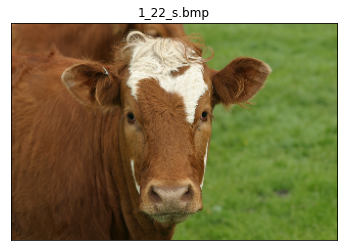

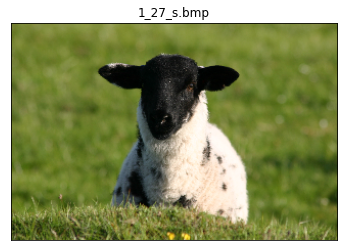

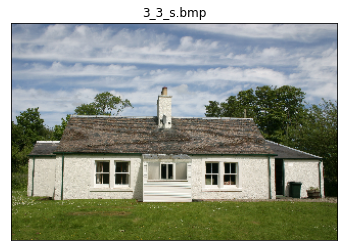

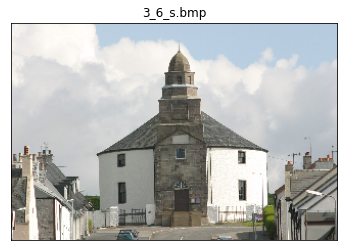

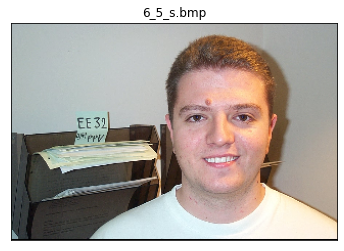

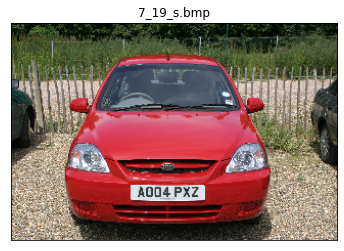

In [ ]:
for i in im_list:
    plot_image(cv2.imread(i),i.split("/")[-1])

Get image and visualize it. Its a scenery with 3 elements. You can see the segmentation ground truth in the GT bitmap.  

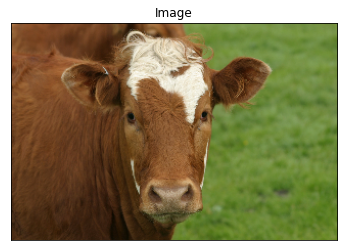

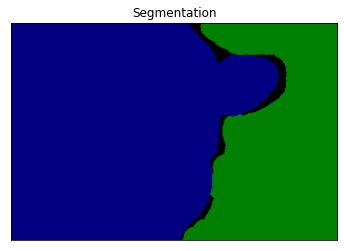

In [ ]:
im = cv2.imread(im_list[0])
seg = cv2.imread(im_list[0].replace("_s","_s_GT"))

plot_image(im,"Image")
plot_image(seg,"Segmentation")


###Question 1: K-means on RGB
We know k-means clustering algorithm. It is an unsupervised algorithm which minimizes within cluster variances(squared euclidean distances) by grouping observations into k groups 
with the centroid of each of the k groups serving as the model of the group.  

Complete the pixel clustering function. It should take input an image (dim = (n $\times$ m  $\times$ 3)) and number of clusters needed. 
Does K means clustering work on image pixels?
Let the number of clusters be K = 5, 10, 50




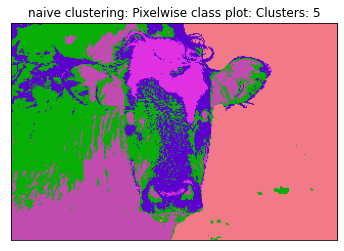

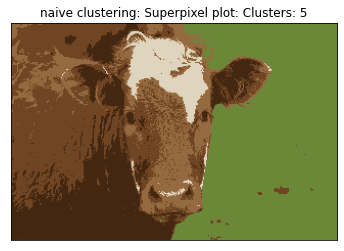

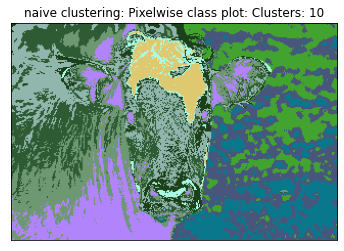

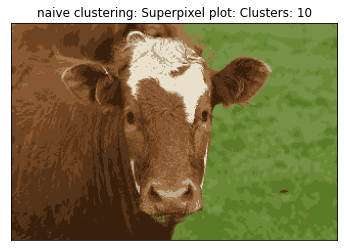

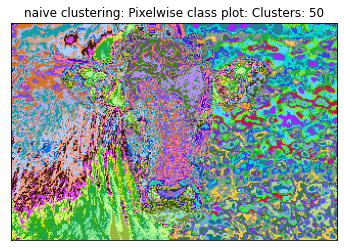

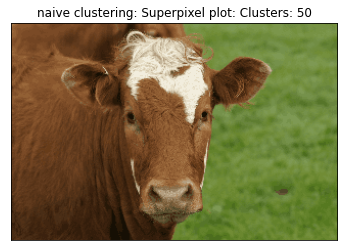

In [ ]:
from sklearn.cluster import KMeans
import numpy as  np
from scipy.spatial import distance_matrix

def cluster_pixels(im,k):
    #Pixelwise clustering   
    #segmap is nXm. Each value in the 2D array is the cluster assigned to that pixel
       
    m,n,o = im.shape
    reshapedData = im.reshape((m*n),o)
     
    u_ind = np.random.choice(reshapedData.shape[0],k,replace = False)                     #initialize centroids 
    u = reshapedData[u_ind]
    labels = None                                                                         #initialize labels

    maxIterations = 500                                 
    for i in range(maxIterations):
        
        clusterPointDist = distance_matrix(reshapedData,u)                                #distance between points and clusters
        labels = np.argmin(clusterPointDist,axis = 1)                                     #label points with smallest dist
        
        old_u = np.array(u)
        u = np.array([np.mean(reshapedData[labels == q],axis = 0) for q in range(k)])     #recompute centroids 
        
        if(np.all(old_u==u)):
          break
    
    segmap = labels.reshape(m,n)
    return segmap


for k in [5,10,50]:
    clusters = cluster_pixels(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

###Question 2: Now that you have a function handy, we have a slightly complex task

Instead of making clustering run on RGB space, run the clustering on RGBXY space. What advantages does that give us? 
(try with clusters = 5, 10, 25, 50, 150)
Including the (x,y)-euclidean neighboring distances  reduces the cluttering of clusters as it becomes easier to group together neighboring pixels. Compare 
output for clusters of size 50 for RGB space to that of RGBXY space. 



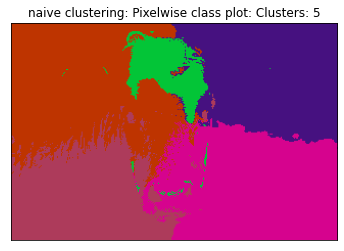

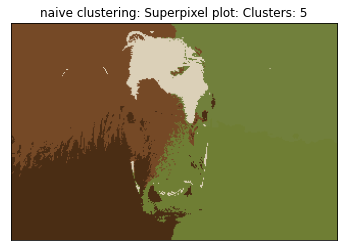

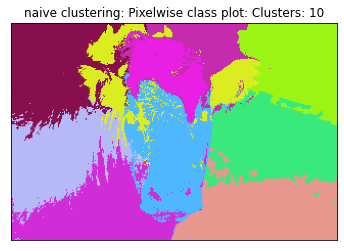

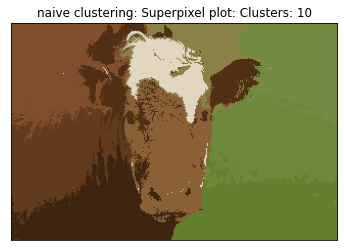

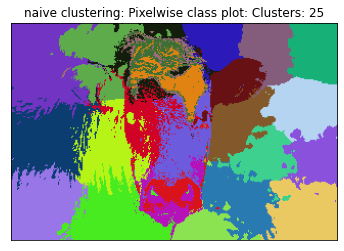

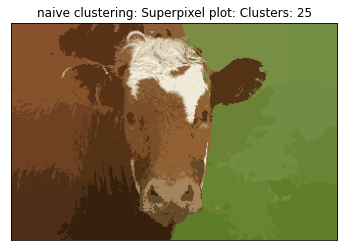

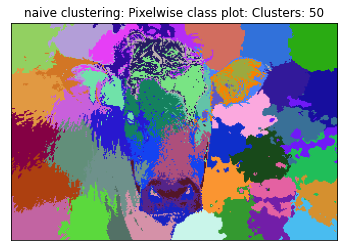

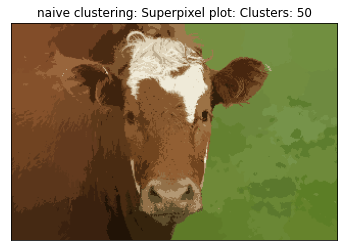

In [ ]:
#TODO: clustering r,b,g,x,y values 
#try k = 20,80,200,400,800

def cluster_rgbxy(im,k):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    
    #Pixelwise clustering   
    #segmap is nXm. Each value in the 2D array is the cluster assigned to that pixel
       
    m,n,o = im.shape
    rgbPoints = im.reshape((m*n),o)
    
    x,y = np.mgrid[0:m,0:n]
    xyPoints = np.column_stack((x.ravel(),y.ravel()))
     
    u_ind = np.random.choice(rgbPoints.shape[0],k)                                 
    u_rgb = rgbPoints[u_ind]                                                                #intialize centroid rgb
    u_xy =  xyPoints[u_ind]                                                                 #initialize centriods xy
    

    labels = None                                                                           #initialize labels

    maxIterations = 500                                 
    for i in range(maxIterations):
        
        rgbPointDist = distance_matrix(rgbPoints,u_rgb)                                     #rgb distance between points and clusters
        xyPointDist =  distance_matrix(xyPoints ,u_xy)
        
        clusterPointDist = rgbPointDist + xyPointDist
        labels = np.argmin(clusterPointDist,axis = 1)                                       #label points with smallest dist
        
        old_u_rgb = np.array(u_rgb)
        old_u_xy = np.array(u_xy)
        u_rgb = np.array([np.mean(rgbPoints[labels == q],axis = 0) for q in range(k)])      #recompute centroids 
        u_xy  = np.array([np.mean(xyPoints[labels == q],axis = 0) for q in range(k)])       #recompute centroids 
        
        if(np.all(old_u_xy==u_xy) and np.all(old_u_rgb == u_rgb)):
              break
    
    segmap = labels.reshape(m,n)
    return segmap


for k in [5, 10, 25, 50]:
    clusters = cluster_rgbxy(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))


###  Modified k-means with weighted distances. 

 Let $cluster\_center_i$ represent $i^{th}$ cluster center, $cluster\_center_i^{rgb}$ denote the RGB value and $cluster\_center_i^{xy}$ be the corresponding coordinate of the center pixel, respectively.
 
 Let $x_{rgb}$ be the the RGB value of a pixel, and let $x_{xy}$ be the corresponding pixel's coordinate.
 <!-- Let $x_{xy}$ be the coordinate of $x_{rgb}$ -->

$distance(x_{rgb},x_{xy}) = \lambda_1 * euclidean(x_{rgb},cluster\_center_{i}^{rgb})  + \lambda_2 * euclidean(x_{xy},cluster\_center_{i}^{xy})$



Find good values for hyperparmeters $\lambda_1$ and $\lambda_2$ (try on 250 clusters)

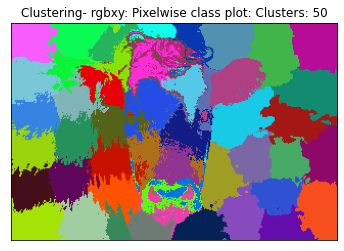

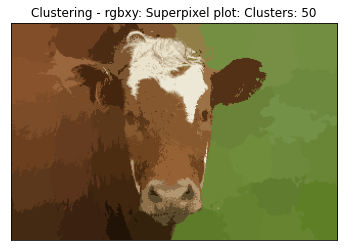

In [ ]:
#TODO: clustering r,b,g,x,y values with lambdas and display outputs
def cluster_rgbxy(im,k, lambda_1, lambda_2):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    
    #Pixelwise clustering   
    #segmap is nXm. Each value in the 2D array is the cluster assigned to that pixel
       
    m,n,o = im.shape
    rgbPoints = im.reshape((m*n),o)
    
    x,y = np.mgrid[0:m,0:n]
    xyPoints = np.column_stack((x.ravel(),y.ravel()))
     
    u_ind = np.random.choice(rgbPoints.shape[0],k)                                 
    u_rgb = rgbPoints[u_ind]                                                                #intialize centroid rgb
    u_xy =  xyPoints[u_ind]                                                                 #initialize centriods xy
    

    labels = None                                                                           #initialize labels

    maxIterations = 50                                 
    for i in range(maxIterations):
        
        rgbPointDist = distance_matrix(rgbPoints,u_rgb)                                     #rgb distance between points and clusters
        xyPointDist =  distance_matrix(xyPoints ,u_xy)
        
        clusterPointDist = lambda_1*rgbPointDist + lambda_2*xyPointDist
        labels = np.argmin(clusterPointDist,axis = 1)                                       #label points with smallest dist
        
        old_u_rgb = np.array(u_rgb)
        old_u_xy = np.array(u_xy)
        u_rgb = np.array([np.mean(rgbPoints[labels == q],axis = 0) for q in range(k)])      #recompute centroids 
        u_xy  = np.array([np.mean(xyPoints[labels == q],axis = 0) for q in range(k)])       #recompute centroids 
        
        if(np.all(old_u_xy==u_xy) and np.all(old_u_rgb == u_rgb)):
              break
    
    segmap = labels.reshape(m,n)
    return segmap

for k in [50]:
    clusters = cluster_rgbxy(im,k, 1, 1.5)
    _ = rgb_segment(clusters,n = k, title =  "Clustering- rgbxy: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "Clustering - rgbxy: Superpixel plot: Clusters: "+ str(k))


###Question 3: SLIC

It doesn't look like we have a very favourable outcome with superpixels simply being implemented as K-means. Can we do better? Have a look at the SLIC paper [here](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). Incorporate S and m and redefine your distance metric as per the paper.


In [ ]:
import cv2
import tqdm
from scipy.spatial import distance_matrix
#TODO
############Algorithm############
#Compute grid steps: S
#you can explore different values of m
#initialize cluster centers [l,a,b,x,y] using  
#Perturb for minimum G
#while not converged
##for every pixel:
####  compare distance D_s with each cluster center within 2S X 2S. 
####  Assign to nearest cluster
##calculate new cluster center 
 

def SLIC(im, k):
    """
    Input arguments: 
    im: image input
    k: number of cluster segments


    Compute
    S: As described in the paper
    m: As described in the paper (use the same value as in the paper)
    follow the algorithm..
    
    returns:
    segmap: 2D matrix where each value corresponds to the image pixel's cluster number
    """
    
    imLab =  cv2.cvtColor(im, cv2.COLOR_BGR2LAB)    
    r,c,d = im.shape
        
    x,y = np.mgrid[0:r,0:c]
    pixels_xy = np.column_stack((x.ravel(),y.ravel()))
    pixels_rgb = imLab.reshape((r*c),d)
    labels = None

    N = imLab.shape[0]*imLab.shape[1]                                             #Compute grid steps: S
    S = int((N/k)**0.5)
    m = 35

    x,y = np.mgrid[0:r-S:S,0:c-S:S] 

    c_xy  = np.column_stack((x.ravel(),y.ravel()))                                #initialize cluster centers
    c_rgb = imLab[c_xy[:,0],c_xy[:,1]]
   
    sobelx = cv2.Sobel(imLab,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(imLab,cv2.CV_64F,0,1,ksize=5)
    G = np.linalg.norm(sobelx,axis = 2)**2 + np.linalg.norm(sobely,axis=2)**2     #Perturb for minimum G
    for i in range(len(c_xy)):
       a,b = c_xy[i]
       region = G[max(a - 1,0):a+1,max(b-1,0):b+1]

       min_x,min_y  = np.where(region == np.min(region))
       perturb_x,perturb_y = min_x[0],min_y[0]
       
       c_xy[i] = [max(a-1,0)+perturb_x, max(b-1,0)+perturb_y]
     
           
    numClusters = len(c_xy)
    maxIterations = 4
    for i in tqdm.tqdm(range(maxIterations)):
        labels = []
        for j in range(r):
            for k in range(c):

                pixel_xy = np.array([j,k])
                pixel_rgb =  imLab[j,k] 
                
                ind = np.where(np.linalg.norm((c_xy - pixel_xy),axis=1)<= 2*S)[0]

                local_c_xy  = c_xy[ind]
                local_c_rgb = c_rgb[ind] 
                
                rgbPointDist = distance_matrix(pixel_rgb.reshape(1,-1),local_c_rgb)[0]
                xyPointDist =  distance_matrix(pixel_xy.reshape(1,-1),local_c_xy)[0]

                local_clusterPointDist = rgbPointDist + (m/S)*xyPointDist  
                labels.append(ind[np.argmin(local_clusterPointDist)])
        
        labels = np.array(labels)
        c_rgb = np.array([np.mean(pixels_rgb[labels == q],axis = 0) for q in range(numClusters)])      
        c_xy  = np.array([np.mean(pixels_xy[labels == q],axis = 0) for q in range(numClusters)])       
    
    segmap = labels.reshape(r,c)
    return segmap



100%|██████████| 4/4 [00:25<00:00,  6.27s/it]


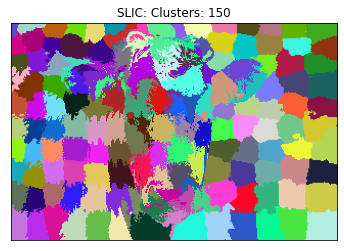

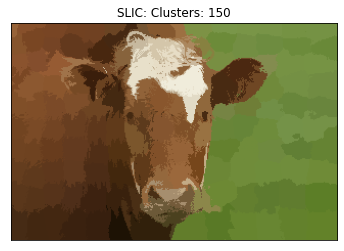

In [ ]:
#TODO diplay your SLIC results.
for k in [150]:
    clusters = SLIC(im,k)
   
    _ = rgb_segment(clusters,n = k, title =  "SLIC: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "SLIC: Clusters: "+ str(k))
    

## Bonus Question:
Enforce connectivity: There are many superpixels which are very small and disconnected from each other. Try to merge them with larger superpixels

O(N) algorithm:
1. Set a minimum size of superpixel
2. If the area of a region is smaller than a threshold, we assign it to the nearest cluster 


  0%|          | 0/4 [00:00<?, ?it/s]

(10, 15)


100%|██████████| 4/4 [00:24<00:00,  6.17s/it]


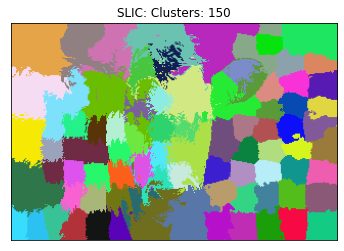

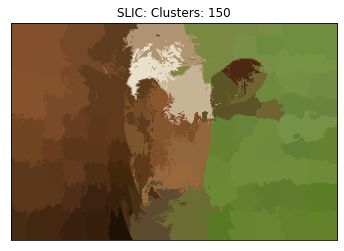

In [ ]:
#TODO
import cv2
import tqdm
from scipy.spatial import distance_matrix
def SLIC(im, k):
    """
    Input arguments: 
    im: image input
    k: number of cluster segments


    Compute
    S: As described in the paper
    m: As described in the paper (use the same value as in the paper)
    follow the algorithm..
    
    returns:
    segmap: 2D matrix where each value corresponds to the image pixel's cluster number
    """
    def isValidIndex(i,j,mat):
       return i>=0 and i<mat.shape[0] and j>=0 and j<mat.shape[1]
    
    imLab =  cv2.cvtColor(im, cv2.COLOR_BGR2LAB)    
    r,c,d = im.shape
        
    x,y = np.mgrid[0:r,0:c]
    pixels_xy = np.column_stack((x.ravel(),y.ravel()))
    pixels_rgb = imLab.reshape((r*c),d)
    labels = None

    N = imLab.shape[0]*imLab.shape[1]                                             #Compute grid steps: S
    S = int((N/k)**0.5)
    m = 35

    x,y = np.mgrid[0:r-S:S,0:c-S:S] 
    print(x.shape)
    c_xy  = np.column_stack((x.ravel(),y.ravel()))                                #initialize cluster centers
    c_rgb = imLab[c_xy[:,0],c_xy[:,1]]
   
   
    sobelx = cv2.Sobel(imLab,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(imLab,cv2.CV_64F,0,1,ksize=5)
    G = np.linalg.norm(sobelx,axis = 2)**2 + np.linalg.norm(sobely,axis=2)**2     #Perturb for minimum G
    for i in range(len(c_xy)):
       a,b = c_xy[i]
       region = G[max(a - 1,0):a+1,max(b-1,0):b+1]

       min_x,min_y  = np.where(region == np.min(region))
       perturb_x,perturb_y = min_x[0],min_y[0]
       
       c_xy[i] = [max(a-1,0)+perturb_x, max(b-1,0)+perturb_y]




    numClusters = len(c_xy)
    maxIterations = 4
    for i in tqdm.tqdm(range(maxIterations)):
        labels = []
        for j in range(r):
            for k in range(c):

                pixel_xy = np.array([j,k])
                pixel_rgb =  imLab[j,k] 
                
                ind = np.where(np.linalg.norm((c_xy - pixel_xy),axis=1)<= 2*S)[0]

                local_c_xy  = c_xy[ind]
                local_c_rgb = c_rgb[ind] 
                
                rgbPointDist = distance_matrix(pixel_rgb.reshape(1,-1),local_c_rgb)[0]
                xyPointDist =  distance_matrix(pixel_xy.reshape(1,-1),local_c_xy)[0]

                local_clusterPointDist = rgbPointDist + (m/S)*xyPointDist  
                labels.append(ind[np.argmin(local_clusterPointDist)])
        
        labels = np.array(labels)
        c_rgb = np.array([np.mean(pixels_rgb[labels == q],axis = 0) for q in range(numClusters)])      
        c_xy  = np.array([np.mean(pixels_xy[labels == q],axis = 0) for q in range(numClusters)])       
    
    ################################################################################################
    ####                                  Connectivity
    ###############################################################################################
    clusterXY = np.expand_dims(c_xy,axis=0)
   
    cluster = clusterXY.reshape(x.shape[0],x.shape[1],2)                          #reshaping clusters for easy access to labels
    
    min_area = S*S
    label_id = 0;
    for i in range(cluster.shape[0]):
        for j in range(cluster.shape[1]):
            
            ind = np.where(labels == label_id)[0]                                 #area of pixels is proprotional to number of pixels assigned to it
            area = len(ind)
            if(area <= min_area):
                ids = [label_id-cluster.shape[1], label_id-cluster.shape[1]-1, label_id-cluster.shape[1]+1,
                       label_id-1,label_id+1,label_id+cluster.shape[1],label_id+cluster.shape[1]-1,label_id+cluster.shape[1]+1]

                u =  len(np.where(labels == ids[0])[0])  if(isValidIndex(i-1,j,cluster))   else 0
                lu = len(np.where(labels == ids[1])[0])  if(isValidIndex(i-1,j-1,cluster)) else 0
                ru = len(np.where(labels == ids[2])[0])  if(isValidIndex(i-1,j+1,cluster)) else 0
                lm = len(np.where(labels == ids[3])[0])  if(isValidIndex(i,j-1,cluster))   else 0
                rm = len(np.where(labels == ids[4])[0])  if(isValidIndex(i,j+1,cluster))   else 0
                b =  len(np.where(labels == ids[5])[0])  if(isValidIndex(i+1,j,cluster))   else 0
                lb = len(np.where(labels == ids[6])[0])  if(isValidIndex(i+1,j-1,cluster)) else 0
                rb = len(np.where(labels == ids[7])[0])  if(isValidIndex(i+1,j+1,cluster)) else 0

                assignlabel_index = np.argmax([u,lu,ru,lm,rm,b,lb,rb])
                
                ind = np.where(labels ==label_id)
                labels[ind] =  ids[assignlabel_index]

            label_id += 1


    segmap = labels.reshape(r,c)
    return segmap


#TODO diplay your SLIC results.
for k in [150]:
    clusters = SLIC(im,k)
   
    _ = rgb_segment(clusters,n = k, title =  "SLIC: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "SLIC: Clusters: "+ str(k))






## Your File
Link to your colab/ipynb file: https://colab.research.google.com/drive/1qUIZVszt2xfEU2wDGFsGDWfKoB2sYY0W#scrollTo=eHADuTUzek39


In [ ]:
!jupyter nbconvert --to PDF "Superpixels.ipnyb"
